# Action Conditional Deep Markov Model using cartpole dataset

In [1]:
from tqdm import tqdm

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter
import numpy as np

from utils import DMMDataset, imshow, postprocess
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


## Prepare Dataset 
you have to run prepare_cartpole_dataset.py or download from :  
https://drive.google.com/drive/folders/1w_97RLFS--CpdUCNw1C-3yPLhceZxkO2?usp=sharing

In [2]:
batch_size = 256
train_loader = DataLoader(DMMDataset(), batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(DMMTestDataset(), batch_size=batch_size, shuffle=False, drop_last=True)

_x = iter(train_loader).next()
print(_x['episode_frames'][0][0:30].shape)

torch.Size([30, 3, 28, 28])


torch.Size([30, 3, 28, 28])


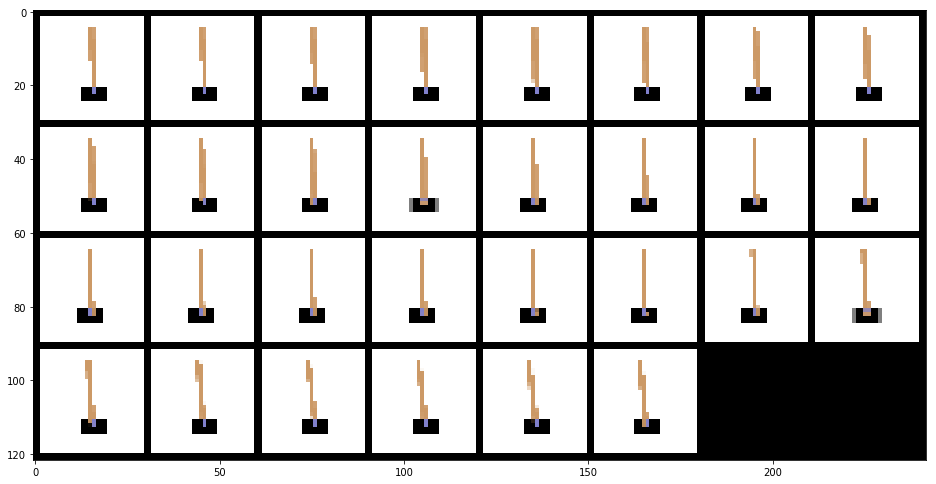

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [3]:
imshow(postprocess(_x['episode_frames'][0][0:30]))

# 0: Push cart to the left
# 1:Push cart to the right
print(_x['actions'][0][0:30])

# for more details about actions: https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/classic_control/cartpole.py#L37
# for more details about CartPole-v1: https://gym.openai.com/envs/CartPole-v1/

In [4]:
from pixyz.utils import print_latex
from pixyz.distributions import Bernoulli, Normal, Deterministic


h_dim = 32
hidden_dim = 32
z_dim = 16
t_max = 30
u_dim = 1

## Deep Markov Model
* Original paper: Structured Inference Networks for Nonlinear State Space Models (https://arxiv.org/abs/1609.09869)
* Original code: https://github.com/clinicalml/dmm


Prior(Transition model): $p_{\theta}(z_{t} | z_{t-1}, u) =  \cal{N}(\mu = f_{prior_\mu}(z_{t-1}, u), \sigma^2 = f_{prior_\sigma^2}(z_{t-1}, u)$    
Generator(Emission): $p_{\theta}(x | z)=\mathscr{B}\left(x ; \lambda=g_{x}(z)\right)$  

RNN: $p(h) = RNN(x)$  
Inference(Combiner): $p_{\phi}(z | h, z_{t-1}, u) = \cal{N}(\mu = f_{\mu}(h, z_{t-1}, u), \sigma^2 = f_{\sigma^2}(h, z_{t-1}, u)$

## Define probability distributions

In [5]:
# RNN
class RNN(Deterministic):
    """
    h = RNN(x)
    Given observed x, RNN output hidden state
    """
    def __init__(self):
        super(RNN, self).__init__(var=["h"], cond_var=["x"])
        
        # 28x28x3 → 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(128*7*7, 256)
        self.fc2 = nn.Linear(256, 32)
        
        self.rnn = nn.GRU(32, h_dim, bidirectional=True)
        self.h0 = nn.Parameter(torch.zeros(2, 1, self.rnn.hidden_size))
        self.hidden_size = self.rnn.hidden_size
        
    def forward(self, x):
        
        h0 = self.h0.expand(2, x.size(1), self.rnn.hidden_size).contiguous()
        x = x.reshape(-1, 3, 28, 28)      # Nx3x28x28

        h = F.relu(self.conv1(x))         # Nx64x14x14
        h = F.relu(self.conv2(h))         # Nx128x7x7
        h = h.view(h.shape[0], 128*7*7)   # Nx128*7*7
        h = F.relu(self.fc1(h))           # Nx256
        h = F.relu(self.fc2(h))           # Nx32
        h = h.reshape(30, -1, 32)         # 30x128x32

        h, _ = self.rnn(h, h0)            # 30x128x32, 1x128x32
        return {"h": h}


# Emission p(x_t | z_t)
class Generator(Normal):
    """
    Given the latent z at time step t, return the vector of
    probabilities that parameterizes the bernlulli distribution p(x_t | z_t)
    """
    def __init__(self):
        super(Generator, self).__init__(var=["x"], cond_var=["z"])
        self.fc1 = nn.Linear(z_dim, 256)
        self.fc2 = nn.Linear(256, 128*7*7)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)        

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = h.view(h.shape[0], 128, 7, 7) # 128*7*7
        h = F.relu(self.conv1(h))         # 64x14x14
        generated_x = self.conv2(h)                 # 3x28x28
        return {"loc": generated_x, "scale": 1.0}


class Inference(Normal):
    """
    given the latent z at time step t-1, the hidden state of the RNN h(x_{0:T} and u
    return the loc and scale vectors that
    parameterize the gaussian distribution q(z_t | z_{t-1}, x_{t:T}, u)
    """
    def __init__(self):
        super(Inference, self).__init__(var=["z"], cond_var=["h", "z_prev", "u"])
        self.fc1 = nn.Linear(z_dim+u_dim, h_dim*2)
        self.fc21 = nn.Linear(h_dim*2, z_dim)
        self.fc22 = nn.Linear(h_dim*2, z_dim)

        
    def forward(self, h, z_prev, u):
        feature = torch.cat((z_prev, u), 1)
        h_z = torch.tanh(self.fc1(feature))
        h = 0.5 * (h + h_z)
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}


class Prior(Normal):
    """
    Given the latent variable at the time step t-1 and u,
    return the mean and scale vectors that parameterize the
    gaussian distribution p(z_t | z_{t-1}, u)
    """
    def __init__(self):
        super(Prior, self).__init__(var=["z"], cond_var=["z_prev", "u"])
        self.fc1 = nn.Linear(z_dim+u_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, z_prev, u):
        feature = torch.cat((z_prev, u), 1)
        h = F.relu(self.fc1(feature))
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}

In [6]:
prior = Prior().to(device)
encoder = Inference().to(device)
decoder = Generator().to(device)
rnn = RNN().to(device)
generate_from_prior = prior * decoder

print_latex(generate_from_prior)

<IPython.core.display.Math object>

## Define loss

In [7]:
from pixyz.losses import KullbackLeibler
from pixyz.losses import Expectation as E
from pixyz.losses import LogProb
from pixyz.losses import IterativeLoss

step_loss = - E(encoder, LogProb(decoder)) + KullbackLeibler(encoder, prior)

# IterativeLoss: https://docs.pixyz.io/en/latest/losses.html#pixyz.losses.IterativeLoss
_loss = IterativeLoss(step_loss, max_iter=t_max, 
                      series_var=["x", "h", "u"], update_value={"z": "z_prev"})
loss = E(rnn, _loss).mean()

In [8]:
from pixyz.models import Model

dmm = Model(loss, distributions=[rnn, encoder, decoder, prior], 
            optimizer=optim.RMSprop, optimizer_params={"lr": 5e-4}, clip_grad_value=10)

print(dmm)
print_latex(dmm)

Distributions (for training): 
  p(h|x), p(z|h,z_{prev},u), p(x|z), p(z|z_{prev},u) 
Loss function: 
  mean \left(\mathbb{E}_{p(h|x)} \left[\sum_{t=1}^{30} \left(D_{KL} \left[p(z|h,z_{prev},u)||p(z|z_{prev},u) \right] - \mathbb{E}_{p(z|h,z_{prev},u)} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.0005
      momentum: 0
      weight_decay: 0
  )


<IPython.core.display.Math object>

## Sampling code

In [9]:
def data_loop(epoch, loader, model, device, train_mode=False):
    mean_loss = 0
    for data in loader:
        x = data['episode_frames'].to(device) # 256,30,3,28,28
        u = data['actions'].to(device) # 256,30,1
        batch_size = x.size()[0]
        x = x.transpose(0, 1) # 30,256,3,28,28
        u = u.transpose(0, 1) # 30,256,1
        z_prev = torch.zeros(batch_size, z_dim).to(device)
        if train_mode:
            mean_loss += model.train({'x': x, 'z_prev': z_prev, 'u': u}).item() * batch_size
        else:
            mean_loss += model.test({'x': x, 'z_prev': z_prev, 'u': u}).item() * batch_size
    mean_loss /= len(loader.dataset)
    if train_mode:
        print('Epoch: {} Train loss: {:.4f}'.format(epoch, mean_loss))
    else:
        print('Test loss: {:.4f}'.format(mean_loss))
    return mean_loss

_data = iter(train_loader).next()
_u = _data['actions'].to(device) # 256,30,1
_u = _u.transpose(0, 1)          # 30,256,1

def plot_video_from_latent(batch_size):
    x = []
    z_prev = torch.zeros(batch_size, z_dim).to(device)
    for step in range(t_max):
        samples = generate_from_prior.sample({'z_prev': z_prev, 'u': _u[step]})
        x_t = decoder.sample_mean({"z": samples["z"]})
        z_prev = samples["z"]
        x.append(x_t[None, :])
    x = torch.cat(x, dim=0).transpose(0, 1)
    return x

## Train

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 Train loss: 135122.8520


  0%|          | 1/200 [00:04<13:35,  4.10s/it]

Epoch: 2 Train loss: 90253.1340


  1%|          | 2/200 [00:08<13:16,  4.02s/it]

Epoch: 3 Train loss: 81096.6820


  2%|▏         | 3/200 [00:11<13:07,  4.00s/it]

Epoch: 4 Train loss: 77355.0100


  2%|▏         | 4/200 [00:15<12:55,  3.96s/it]

Epoch: 5 Train loss: 73845.4700


  2%|▎         | 5/200 [00:19<12:48,  3.94s/it]

Epoch: 6 Train loss: 72047.6200


  3%|▎         | 6/200 [00:23<12:43,  3.94s/it]

Epoch: 7 Train loss: 69971.1520


  4%|▎         | 7/200 [00:27<12:37,  3.93s/it]

Epoch: 8 Train loss: 69165.3120


  4%|▍         | 8/200 [00:31<12:31,  3.92s/it]

Epoch: 9 Train loss: 68188.5620


  4%|▍         | 9/200 [00:35<12:28,  3.92s/it]

Epoch: 10 Train loss: 67598.2300


  5%|▌         | 10/200 [00:39<12:23,  3.91s/it]

Epoch: 11 Train loss: 67193.7760


  6%|▌         | 11/200 [00:43<12:19,  3.91s/it]

Epoch: 12 Train loss: 66844.7420


  6%|▌         | 12/200 [00:47<12:16,  3.92s/it]

Epoch: 13 Train loss: 66364.0060


  6%|▋         | 13/200 [00:50<12:11,  3.91s/it]

Epoch: 14 Train loss: 66334.7240


  7%|▋         | 14/200 [00:54<12:09,  3.92s/it]

Epoch: 15 Train loss: 65878.0960


  8%|▊         | 15/200 [00:58<12:04,  3.92s/it]

Epoch: 16 Train loss: 65880.0440


  8%|▊         | 16/200 [01:02<11:59,  3.91s/it]

Epoch: 17 Train loss: 65475.5400


  8%|▊         | 17/200 [01:06<11:54,  3.90s/it]

Epoch: 18 Train loss: 65414.8520


  9%|▉         | 18/200 [01:10<11:49,  3.90s/it]

Epoch: 19 Train loss: 64852.2780


 10%|▉         | 19/200 [01:14<11:45,  3.90s/it]

Epoch: 20 Train loss: 64408.8360


 10%|█         | 20/200 [01:17<11:40,  3.89s/it]

Epoch: 21 Train loss: 63974.0380


 10%|█         | 21/200 [01:21<11:35,  3.89s/it]

Epoch: 22 Train loss: 63630.9260


 11%|█         | 22/200 [01:25<11:31,  3.88s/it]

Epoch: 23 Train loss: 63318.6640


 12%|█▏        | 23/200 [01:29<11:26,  3.88s/it]

Epoch: 24 Train loss: 63170.1460


 12%|█▏        | 24/200 [01:33<11:22,  3.88s/it]

Epoch: 25 Train loss: 62920.6320


 12%|█▎        | 25/200 [01:36<11:18,  3.88s/it]

Epoch: 26 Train loss: 62751.3140


 13%|█▎        | 26/200 [01:40<11:14,  3.87s/it]

Epoch: 27 Train loss: 62510.9520


 14%|█▎        | 27/200 [01:44<11:10,  3.87s/it]

Epoch: 28 Train loss: 62588.4360


 14%|█▍        | 28/200 [01:48<11:06,  3.88s/it]

Epoch: 29 Train loss: 61929.8660


 14%|█▍        | 29/200 [01:52<11:02,  3.88s/it]

Epoch: 30 Train loss: 61316.8060


 15%|█▌        | 30/200 [01:56<10:58,  3.88s/it]

Epoch: 31 Train loss: 60486.2660


 16%|█▌        | 31/200 [02:00<10:54,  3.88s/it]

Epoch: 32 Train loss: 60001.6220


 16%|█▌        | 32/200 [02:04<10:51,  3.88s/it]

Epoch: 33 Train loss: 59460.8240


 16%|█▋        | 33/200 [02:07<10:47,  3.88s/it]

Epoch: 34 Train loss: 59289.5080


 17%|█▋        | 34/200 [02:11<10:43,  3.87s/it]

Epoch: 35 Train loss: 59073.3060


 18%|█▊        | 35/200 [02:15<10:39,  3.88s/it]

Epoch: 36 Train loss: 58960.7100


 18%|█▊        | 36/200 [02:19<10:35,  3.87s/it]

Epoch: 37 Train loss: 58642.3800


 18%|█▊        | 37/200 [02:23<10:30,  3.87s/it]

Epoch: 38 Train loss: 58429.8240


 19%|█▉        | 38/200 [02:27<10:26,  3.87s/it]

Epoch: 39 Train loss: 58304.1100


 20%|█▉        | 39/200 [02:30<10:22,  3.87s/it]

Epoch: 40 Train loss: 58185.2540


 20%|██        | 40/200 [02:34<10:18,  3.87s/it]

Epoch: 41 Train loss: 57996.4080


 20%|██        | 41/200 [02:38<10:14,  3.86s/it]

Epoch: 42 Train loss: 57931.2140


 21%|██        | 42/200 [02:42<10:10,  3.86s/it]

Epoch: 43 Train loss: 57737.4840


 22%|██▏       | 43/200 [02:45<10:05,  3.86s/it]

Epoch: 44 Train loss: 57706.4700


 22%|██▏       | 44/200 [02:49<10:01,  3.86s/it]

Epoch: 45 Train loss: 57439.6060


 22%|██▎       | 45/200 [02:53<09:57,  3.86s/it]

Epoch: 46 Train loss: 57463.6020


 23%|██▎       | 46/200 [02:57<09:53,  3.85s/it]

Epoch: 47 Train loss: 57285.5520


 24%|██▎       | 47/200 [03:01<09:49,  3.85s/it]

Epoch: 48 Train loss: 57247.4760


 24%|██▍       | 48/200 [03:04<09:45,  3.85s/it]

Epoch: 49 Train loss: 57086.2280


 24%|██▍       | 49/200 [03:08<09:41,  3.85s/it]

Epoch: 50 Train loss: 56966.7360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

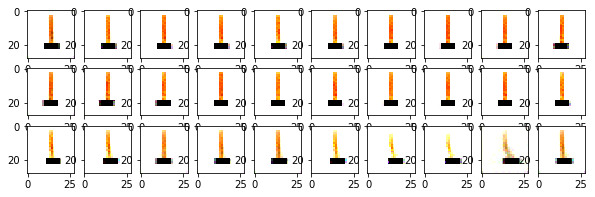

 25%|██▌       | 50/200 [03:13<09:41,  3.88s/it]

Epoch: 51 Train loss: 56824.1820


 26%|██▌       | 51/200 [03:17<09:37,  3.88s/it]

Epoch: 52 Train loss: 56812.5080


 26%|██▌       | 52/200 [03:21<09:34,  3.88s/it]

Epoch: 53 Train loss: 56666.7160


 26%|██▋       | 53/200 [03:25<09:30,  3.88s/it]

Epoch: 54 Train loss: 56668.7020


 27%|██▋       | 54/200 [03:29<09:26,  3.88s/it]

Epoch: 55 Train loss: 56497.9160


 28%|██▊       | 55/200 [03:33<09:22,  3.88s/it]

Epoch: 56 Train loss: 56479.9800


 28%|██▊       | 56/200 [03:37<09:18,  3.88s/it]

Epoch: 57 Train loss: 56297.6360


 28%|██▊       | 57/200 [03:41<09:14,  3.88s/it]

Epoch: 58 Train loss: 56295.1740


 29%|██▉       | 58/200 [03:44<09:10,  3.88s/it]

Epoch: 59 Train loss: 56162.6200


 30%|██▉       | 59/200 [03:48<09:06,  3.88s/it]

Epoch: 60 Train loss: 56182.1080


 30%|███       | 60/200 [03:52<09:02,  3.88s/it]

Epoch: 61 Train loss: 56106.6000


 30%|███       | 61/200 [03:56<08:58,  3.88s/it]

Epoch: 62 Train loss: 56055.0940


 31%|███       | 62/200 [04:00<08:54,  3.88s/it]

Epoch: 63 Train loss: 55902.8800


 32%|███▏      | 63/200 [04:04<08:51,  3.88s/it]

Epoch: 64 Train loss: 55918.1920


 32%|███▏      | 64/200 [04:08<08:47,  3.88s/it]

Epoch: 65 Train loss: 55805.0120


 32%|███▎      | 65/200 [04:11<08:43,  3.88s/it]

Epoch: 66 Train loss: 55797.4460


 33%|███▎      | 66/200 [04:15<08:39,  3.88s/it]

Epoch: 67 Train loss: 55713.8000


 34%|███▎      | 67/200 [04:19<08:35,  3.88s/it]

Epoch: 68 Train loss: 55664.8560


 34%|███▍      | 68/200 [04:23<08:31,  3.88s/it]

Epoch: 69 Train loss: 55576.3620


 34%|███▍      | 69/200 [04:27<08:27,  3.88s/it]

Epoch: 70 Train loss: 55548.3420


 35%|███▌      | 70/200 [04:31<08:23,  3.88s/it]

Epoch: 71 Train loss: 55429.2280


 36%|███▌      | 71/200 [04:35<08:20,  3.88s/it]

Epoch: 72 Train loss: 55480.1360


 36%|███▌      | 72/200 [04:39<08:16,  3.88s/it]

Epoch: 73 Train loss: 55372.8140


 36%|███▋      | 73/200 [04:43<08:12,  3.88s/it]

Epoch: 74 Train loss: 55322.9160


 37%|███▋      | 74/200 [04:46<08:08,  3.88s/it]

Epoch: 75 Train loss: 55238.1540


 38%|███▊      | 75/200 [04:50<08:04,  3.88s/it]

Epoch: 76 Train loss: 55280.2400


 38%|███▊      | 76/200 [04:54<08:00,  3.88s/it]

Epoch: 77 Train loss: 55179.4380


 38%|███▊      | 77/200 [04:58<07:57,  3.88s/it]

Epoch: 78 Train loss: 55209.4780


 39%|███▉      | 78/200 [05:02<07:53,  3.88s/it]

Epoch: 79 Train loss: 55079.0920


 40%|███▉      | 79/200 [05:06<07:49,  3.88s/it]

Epoch: 80 Train loss: 55045.5060


 40%|████      | 80/200 [05:10<07:45,  3.88s/it]

Epoch: 81 Train loss: 55030.6360


 40%|████      | 81/200 [05:13<07:41,  3.88s/it]

Epoch: 82 Train loss: 55005.8220


 41%|████      | 82/200 [05:17<07:37,  3.88s/it]

Epoch: 83 Train loss: 54929.9360


 42%|████▏     | 83/200 [05:21<07:33,  3.88s/it]

Epoch: 84 Train loss: 54969.1100


 42%|████▏     | 84/200 [05:25<07:29,  3.88s/it]

Epoch: 85 Train loss: 54869.3160


 42%|████▎     | 85/200 [05:29<07:25,  3.88s/it]

Epoch: 86 Train loss: 54861.0800


 43%|████▎     | 86/200 [05:33<07:21,  3.88s/it]

Epoch: 87 Train loss: 54751.7260


 44%|████▎     | 87/200 [05:37<07:17,  3.88s/it]

Epoch: 88 Train loss: 54815.0680


 44%|████▍     | 88/200 [05:41<07:14,  3.88s/it]

Epoch: 89 Train loss: 54739.2640


 44%|████▍     | 89/200 [05:44<07:10,  3.87s/it]

Epoch: 90 Train loss: 54757.9560


 45%|████▌     | 90/200 [05:48<07:06,  3.88s/it]

Epoch: 91 Train loss: 54705.2020


 46%|████▌     | 91/200 [05:52<07:02,  3.88s/it]

Epoch: 92 Train loss: 54654.3220


 46%|████▌     | 92/200 [05:56<06:58,  3.88s/it]

Epoch: 93 Train loss: 54617.0460


 46%|████▋     | 93/200 [06:00<06:54,  3.87s/it]

Epoch: 94 Train loss: 54623.8140


 47%|████▋     | 94/200 [06:04<06:50,  3.88s/it]

Epoch: 95 Train loss: 54542.4060


 48%|████▊     | 95/200 [06:08<06:46,  3.88s/it]

Epoch: 96 Train loss: 54619.6100


 48%|████▊     | 96/200 [06:12<06:43,  3.88s/it]

Epoch: 97 Train loss: 54504.6980


 48%|████▊     | 97/200 [06:16<06:39,  3.88s/it]

Epoch: 98 Train loss: 54569.3900


 49%|████▉     | 98/200 [06:19<06:35,  3.88s/it]

Epoch: 99 Train loss: 54432.7600


 50%|████▉     | 99/200 [06:23<06:31,  3.88s/it]

Epoch: 100 Train loss: 54470.5920


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

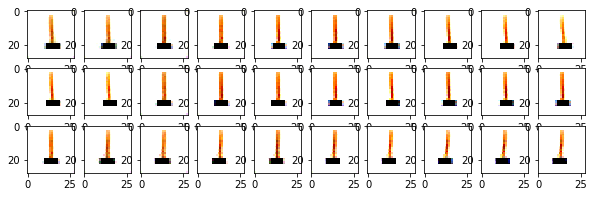

 50%|█████     | 100/200 [06:29<06:29,  3.89s/it]

Epoch: 101 Train loss: 54403.0380


 50%|█████     | 101/200 [06:33<06:25,  3.89s/it]

Epoch: 102 Train loss: 54435.0420


 51%|█████     | 102/200 [06:36<06:21,  3.89s/it]

Epoch: 103 Train loss: 54357.4960


 52%|█████▏    | 103/200 [06:40<06:17,  3.89s/it]

Epoch: 104 Train loss: 54368.0540


 52%|█████▏    | 104/200 [06:44<06:13,  3.89s/it]

Epoch: 105 Train loss: 54305.8840


 52%|█████▎    | 105/200 [06:48<06:09,  3.89s/it]

Epoch: 106 Train loss: 54326.0220


 53%|█████▎    | 106/200 [06:52<06:05,  3.89s/it]

Epoch: 107 Train loss: 54248.3700


 54%|█████▎    | 107/200 [06:55<06:01,  3.89s/it]

Epoch: 108 Train loss: 54299.8040


 54%|█████▍    | 108/200 [06:59<05:57,  3.89s/it]

Epoch: 109 Train loss: 54227.2680


 55%|█████▍    | 109/200 [07:03<05:53,  3.89s/it]

Epoch: 110 Train loss: 54208.4380


 55%|█████▌    | 110/200 [07:07<05:49,  3.89s/it]

Epoch: 111 Train loss: 54137.3380


 56%|█████▌    | 111/200 [07:11<05:45,  3.89s/it]

Epoch: 112 Train loss: 54148.8340


 56%|█████▌    | 112/200 [07:15<05:41,  3.89s/it]

Epoch: 113 Train loss: 54160.9420


 56%|█████▋    | 113/200 [07:19<05:37,  3.88s/it]

Epoch: 114 Train loss: 54132.4100


 57%|█████▋    | 114/200 [07:22<05:34,  3.88s/it]

Epoch: 115 Train loss: 54045.9820


 57%|█████▊    | 115/200 [07:26<05:30,  3.88s/it]

Epoch: 116 Train loss: 54099.1520


 58%|█████▊    | 116/200 [07:30<05:26,  3.88s/it]

Epoch: 117 Train loss: 54069.4480


 58%|█████▊    | 117/200 [07:34<05:22,  3.88s/it]

Epoch: 118 Train loss: 54081.5580


 59%|█████▉    | 118/200 [07:38<05:18,  3.88s/it]

Epoch: 119 Train loss: 54045.7140


 60%|█████▉    | 119/200 [07:41<05:14,  3.88s/it]

Epoch: 120 Train loss: 54002.5400


 60%|██████    | 120/200 [07:45<05:10,  3.88s/it]

Epoch: 121 Train loss: 53965.1260


 60%|██████    | 121/200 [07:49<05:06,  3.88s/it]

Epoch: 122 Train loss: 53992.2380


 61%|██████    | 122/200 [07:53<05:02,  3.88s/it]

Epoch: 123 Train loss: 53972.8280


 62%|██████▏   | 123/200 [07:57<04:58,  3.88s/it]

Epoch: 124 Train loss: 53969.1620


 62%|██████▏   | 124/200 [08:01<04:54,  3.88s/it]

Epoch: 125 Train loss: 53927.5200


 62%|██████▎   | 125/200 [08:04<04:50,  3.88s/it]

Epoch: 126 Train loss: 53964.3320


 63%|██████▎   | 126/200 [08:08<04:47,  3.88s/it]

Epoch: 127 Train loss: 53869.5820


 64%|██████▎   | 127/200 [08:12<04:43,  3.88s/it]

Epoch: 128 Train loss: 53871.5780


 64%|██████▍   | 128/200 [08:16<04:39,  3.88s/it]

Epoch: 129 Train loss: 53859.7800


 64%|██████▍   | 129/200 [08:20<04:35,  3.88s/it]

Epoch: 130 Train loss: 53908.0260


 65%|██████▌   | 130/200 [08:24<04:31,  3.88s/it]

Epoch: 131 Train loss: 53837.9960


 66%|██████▌   | 131/200 [08:27<04:27,  3.88s/it]

Epoch: 132 Train loss: 53871.7580


 66%|██████▌   | 132/200 [08:31<04:23,  3.88s/it]

Epoch: 133 Train loss: 53799.4480


 66%|██████▋   | 133/200 [08:35<04:19,  3.88s/it]

Epoch: 134 Train loss: 53817.8300


 67%|██████▋   | 134/200 [08:39<04:15,  3.88s/it]

Epoch: 135 Train loss: 53753.9780


 68%|██████▊   | 135/200 [08:43<04:11,  3.88s/it]

Epoch: 136 Train loss: 53785.4380


 68%|██████▊   | 136/200 [08:47<04:08,  3.88s/it]

Epoch: 137 Train loss: 53714.4720


 68%|██████▊   | 137/200 [08:50<04:04,  3.88s/it]

Epoch: 138 Train loss: 53829.2060


 69%|██████▉   | 138/200 [08:54<04:00,  3.88s/it]

Epoch: 139 Train loss: 53734.8520


 70%|██████▉   | 139/200 [08:58<03:56,  3.87s/it]

Epoch: 140 Train loss: 53774.9560


 70%|███████   | 140/200 [09:02<03:52,  3.87s/it]

Epoch: 141 Train loss: 53710.4300


 70%|███████   | 141/200 [09:06<03:48,  3.87s/it]

Epoch: 142 Train loss: 53724.4580


 71%|███████   | 142/200 [09:09<03:44,  3.87s/it]

Epoch: 143 Train loss: 53684.8880


 72%|███████▏  | 143/200 [09:13<03:40,  3.87s/it]

Epoch: 144 Train loss: 53695.5900


 72%|███████▏  | 144/200 [09:17<03:36,  3.87s/it]

Epoch: 145 Train loss: 53645.0780


 72%|███████▎  | 145/200 [09:21<03:32,  3.87s/it]

Epoch: 146 Train loss: 53627.6320


 73%|███████▎  | 146/200 [09:25<03:29,  3.87s/it]

Epoch: 147 Train loss: 53627.0840


 74%|███████▎  | 147/200 [09:29<03:25,  3.87s/it]

Epoch: 148 Train loss: 53624.9380


 74%|███████▍  | 148/200 [09:32<03:21,  3.87s/it]

Epoch: 149 Train loss: 53569.0120


 74%|███████▍  | 149/200 [09:36<03:17,  3.87s/it]

Epoch: 150 Train loss: 53564.5840


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

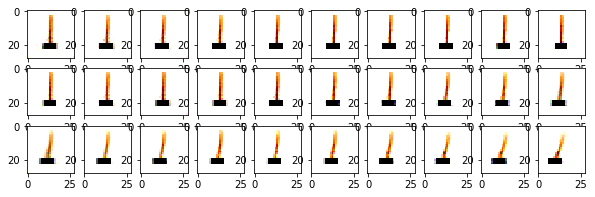

 75%|███████▌  | 150/200 [09:41<03:13,  3.88s/it]

Epoch: 151 Train loss: 53580.5680


 76%|███████▌  | 151/200 [09:45<03:10,  3.88s/it]

Epoch: 152 Train loss: 53582.3500


 76%|███████▌  | 152/200 [09:49<03:06,  3.88s/it]

Epoch: 153 Train loss: 53538.7780


 76%|███████▋  | 153/200 [09:53<03:02,  3.88s/it]

Epoch: 154 Train loss: 53602.6540


 77%|███████▋  | 154/200 [09:57<02:58,  3.88s/it]

Epoch: 155 Train loss: 53534.8760


 78%|███████▊  | 155/200 [10:00<02:54,  3.88s/it]

Epoch: 156 Train loss: 53510.2260


 78%|███████▊  | 156/200 [10:04<02:50,  3.88s/it]

Epoch: 157 Train loss: 53473.8100


 78%|███████▊  | 157/200 [10:08<02:46,  3.88s/it]

Epoch: 158 Train loss: 53535.6280


 79%|███████▉  | 158/200 [10:12<02:42,  3.88s/it]

Epoch: 159 Train loss: 53473.0280


 80%|███████▉  | 159/200 [10:16<02:38,  3.88s/it]

Epoch: 160 Train loss: 53514.6540


 80%|████████  | 160/200 [10:19<02:34,  3.87s/it]

Epoch: 161 Train loss: 53455.0380


 80%|████████  | 161/200 [10:23<02:31,  3.88s/it]

Epoch: 162 Train loss: 53475.0180


 81%|████████  | 162/200 [10:27<02:27,  3.88s/it]

Epoch: 163 Train loss: 53475.7480


 82%|████████▏ | 163/200 [10:31<02:23,  3.88s/it]

Epoch: 164 Train loss: 53454.6420


 82%|████████▏ | 164/200 [10:35<02:19,  3.88s/it]

Epoch: 165 Train loss: 53427.2280


 82%|████████▎ | 165/200 [10:39<02:15,  3.88s/it]

Epoch: 166 Train loss: 53426.8360


 83%|████████▎ | 166/200 [10:43<02:11,  3.88s/it]

Epoch: 167 Train loss: 53390.6420


 84%|████████▎ | 167/200 [10:47<02:07,  3.88s/it]

Epoch: 168 Train loss: 53409.6440


 84%|████████▍ | 168/200 [10:51<02:04,  3.88s/it]

Epoch: 169 Train loss: 53358.5380


 84%|████████▍ | 169/200 [10:55<02:00,  3.88s/it]

Epoch: 170 Train loss: 53430.7460


 85%|████████▌ | 170/200 [10:59<01:56,  3.88s/it]

Epoch: 171 Train loss: 53373.2400


 86%|████████▌ | 171/200 [11:03<01:52,  3.88s/it]

Epoch: 172 Train loss: 53368.7840


 86%|████████▌ | 172/200 [11:06<01:48,  3.88s/it]

Epoch: 173 Train loss: 53353.5260


 86%|████████▋ | 173/200 [11:10<01:44,  3.88s/it]

Epoch: 174 Train loss: 53360.5540


 87%|████████▋ | 174/200 [11:14<01:40,  3.88s/it]

Epoch: 175 Train loss: 53351.1160


 88%|████████▊ | 175/200 [11:18<01:36,  3.88s/it]

Epoch: 176 Train loss: 53340.8240


 88%|████████▊ | 176/200 [11:22<01:33,  3.88s/it]

Epoch: 177 Train loss: 53299.8320


 88%|████████▊ | 177/200 [11:26<01:29,  3.88s/it]

Epoch: 178 Train loss: 53322.5840


 89%|████████▉ | 178/200 [11:30<01:25,  3.88s/it]

Epoch: 179 Train loss: 53275.7780


 90%|████████▉ | 179/200 [11:34<01:21,  3.88s/it]

Epoch: 180 Train loss: 53316.4840


 90%|█████████ | 180/200 [11:38<01:17,  3.88s/it]

Epoch: 181 Train loss: 53294.6960


 90%|█████████ | 181/200 [11:42<01:13,  3.88s/it]

Epoch: 182 Train loss: 53332.1500


 91%|█████████ | 182/200 [11:46<01:09,  3.88s/it]

Epoch: 183 Train loss: 53249.3300


 92%|█████████▏| 183/200 [11:49<01:05,  3.88s/it]

Epoch: 184 Train loss: 53328.4840


 92%|█████████▏| 184/200 [11:53<01:02,  3.88s/it]

Epoch: 185 Train loss: 53218.7080


 92%|█████████▎| 185/200 [11:57<00:58,  3.88s/it]

Epoch: 186 Train loss: 53264.6480


 93%|█████████▎| 186/200 [12:01<00:54,  3.88s/it]

Epoch: 187 Train loss: 53213.9380


 94%|█████████▎| 187/200 [12:05<00:50,  3.88s/it]

Epoch: 188 Train loss: 53233.1180


 94%|█████████▍| 188/200 [12:09<00:46,  3.88s/it]

Epoch: 189 Train loss: 53181.2920


 94%|█████████▍| 189/200 [12:13<00:42,  3.88s/it]

Epoch: 190 Train loss: 53215.2880


 95%|█████████▌| 190/200 [12:17<00:38,  3.88s/it]

Epoch: 191 Train loss: 53185.2100


 96%|█████████▌| 191/200 [12:21<00:34,  3.88s/it]

Epoch: 192 Train loss: 53215.6580


 96%|█████████▌| 192/200 [12:24<00:31,  3.88s/it]

Epoch: 193 Train loss: 53168.9000


 96%|█████████▋| 193/200 [12:28<00:27,  3.88s/it]

Epoch: 194 Train loss: 53181.8680


 97%|█████████▋| 194/200 [12:32<00:23,  3.88s/it]

Epoch: 195 Train loss: 53125.8080


 98%|█████████▊| 195/200 [12:36<00:19,  3.88s/it]

Epoch: 196 Train loss: 53162.7740


 98%|█████████▊| 196/200 [12:40<00:15,  3.88s/it]

Epoch: 197 Train loss: 53161.7220


 98%|█████████▊| 197/200 [12:44<00:11,  3.88s/it]

Epoch: 198 Train loss: 53189.5240


 99%|█████████▉| 198/200 [12:47<00:07,  3.88s/it]

Epoch: 199 Train loss: 53112.2320


100%|█████████▉| 199/200 [12:51<00:03,  3.88s/it]

Epoch: 200 Train loss: 53137.6600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

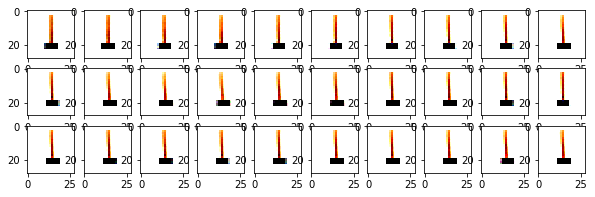

100%|██████████| 200/200 [12:56<00:00,  3.88s/it]


In [10]:
epochs = 200
for epoch in tqdm(range(1, epochs + 1)):
    train_loss = data_loop(epoch, train_loader, dmm, device, train_mode=True)
    sample = plot_video_from_latent(batch_size)
    if epoch % 50 == 0:
        plt.figure(figsize=(10,3))
        for i in range(30):
            plt.subplot(3,10,i+1)
            plt.imshow(sample[0][i].cpu().detach().numpy().astype(np.float).reshape(3,28,28).transpose(1,2,0))
        plt.show()

torch.Size([30, 3, 28, 28])


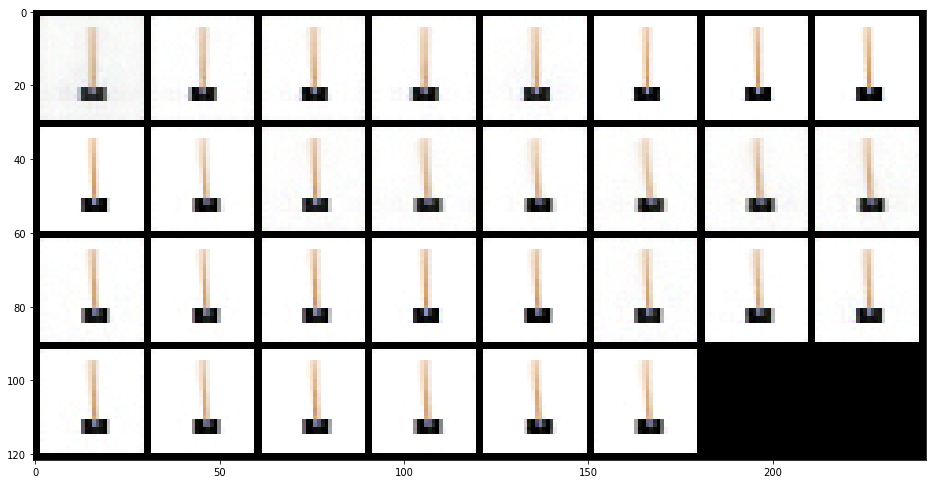

In [13]:
imshow(postprocess(sample[0].cpu().detach()))

torch.Size([30, 3, 28, 28])


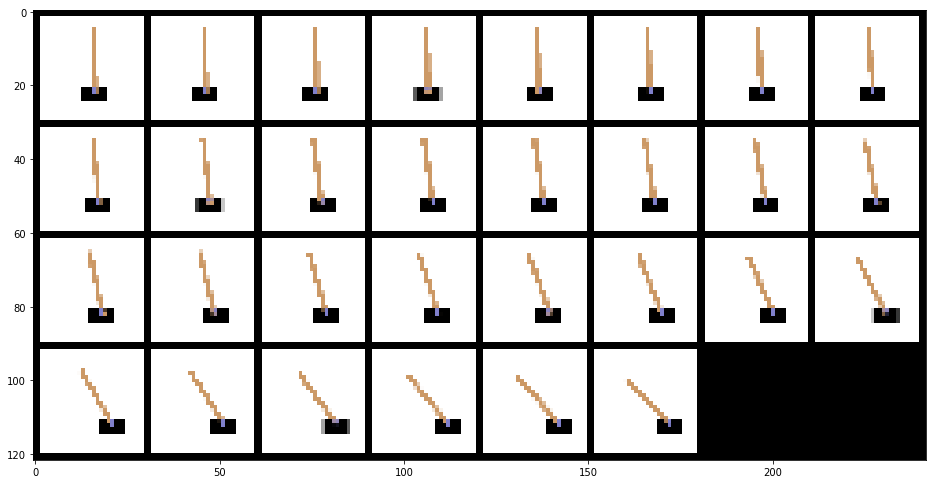

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]])


In [14]:
imshow(postprocess(_data["episode_frames"][0]))
print(_data["actions"][0])